# SARMAX Forecasting

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
#from sktime.forecasting import arima
%load_ext autoreload 
%autoreload 2
import functions as fun

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Model

In [20]:
# # load the dataset
# dataset = pd.read_csv('training_data.csv')
# # dropp unncecassary columns
# dataset = dataset.drop(['Unnamed: 0'], axis = 1)
# dataset.head()

In [21]:
dataset = pd.read_csv('target.csv')
features = pd.read_csv('features.csv')
features.head()

,Unnamed: 0,epoch_utc,datetime_de,windon_forecast,windoff_forecast,solar_forecast,prices_forecast,aggregated_generation_forecast,AT_import,AT_export,...,day_of_week_mon,day_of_week_sat,day_of_week_sun,day_of_week_thu,day_of_week_tue,day_of_week_wed,hour_of_day_sin,hour_of_day_cos,hour_of_year_sin,hour_of_year_cos
0,0,1.546297e+09,2018-12-31 23:00:00+00:00,18879.75,5069.00,0.0,28.32,57054.0,61.0,4940.0,...,1,0,0,0,0,0,-0.258819,0.965926,-0.000717,1.000000
1,1,1.546301e+09,2019-01-01 00:00:00+00:00,20626.50,5042.25,0.0,10.07,57400.0,60.0,5073.0,...,0,0,0,0,1,0,0.000000,1.000000,0.000000,1.000000
2,2,1.546304e+09,2019-01-01 01:00:00+00:00,22355.50,5028.50,0.0,-4.08,57275.0,20.0,4284.0,...,0,0,0,0,1,0,0.258819,0.965926,0.000717,1.000000
3,3,1.546308e+09,2019-01-01 02:00:00+00:00,24032.50,4977.75,0.0,-9.91,58024.0,3.0,4273.0,...,0,0,0,0,1,0,0.500000,0.866025,0.001435,0.999999
4,4,1.546312e+09,2019-01-01 03:00:00+00:00,25452.00,4907.25,0.0,-7.41,59301.0,0.0,4961.0,...,0,0,0,0,1,0,0.707107,0.707107,0.002152,0.999998


In [22]:
features = features.sort_values(by='epoch_utc')

In [23]:
features = features.reset_index()
features = features.drop(columns=['index'])
features

,Unnamed: 0,epoch_utc,datetime_de,windon_forecast,windoff_forecast,solar_forecast,prices_forecast,aggregated_generation_forecast,AT_import,AT_export,...,day_of_week_mon,day_of_week_sat,day_of_week_sun,day_of_week_thu,day_of_week_tue,day_of_week_wed,hour_of_day_sin,hour_of_day_cos,hour_of_year_sin,hour_of_year_cos
0,0,1.546297e+09,2018-12-31 23:00:00+00:00,18879.75,5069.00,0.0,28.320,57054.0,61.0,4940.0,...,1,0,0,0,0,0,-0.258819,9.659258e-01,-0.000717,1.000000
1,1,1.546301e+09,2019-01-01 00:00:00+00:00,20626.50,5042.25,0.0,10.070,57400.0,60.0,5073.0,...,0,0,0,0,1,0,0.000000,1.000000e+00,0.000000,1.000000
2,2,1.546304e+09,2019-01-01 01:00:00+00:00,22355.50,5028.50,0.0,-4.080,57275.0,20.0,4284.0,...,0,0,0,0,1,0,0.258819,9.659258e-01,0.000717,1.000000
3,3,1.546308e+09,2019-01-01 02:00:00+00:00,24032.50,4977.75,0.0,-9.910,58024.0,3.0,4273.0,...,0,0,0,0,1,0,0.500000,8.660254e-01,0.001435,0.999999
4,4,1.546312e+09,2019-01-01 03:00:00+00:00,25452.00,4907.25,0.0,-7.410,59301.0,0.0,4961.0,...,0,0,0,0,1,0,0.707107,7.071068e-01,0.002152,0.999998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36763,36763,1.678644e+09,2023-03-12 18:00:00+00:00,22514.75,4385.50,0.0,130.422,58176.0,0.0,2286.0,...,0,0,1,0,0,0,-1.000000,-1.836970e-16,0.938377,0.345612
36764,36764,1.678648e+09,2023-03-12 19:00:00+00:00,23578.00,4326.75,0.0,110.600,57478.0,0.0,2648.0,...,0,0,1,0,0,0,-0.965926,2.588190e-01,0.938625,0.344939
36765,36765,1.678651e+09,2023-03-12 20:00:00+00:00,24823.25,4386.00,0.0,100.600,56175.0,0.0,2591.0,...,0,0,1,0,0,0,-0.866025,5.000000e-01,0.938872,0.344266
36766,36766,1.678655e+09,2023-03-12 21:00:00+00:00,25471.50,4231.00,0.0,95.776,55808.0,0.0,3143.0,...,0,0,1,0,0,0,-0.707107,7.071068e-01,0.939119,0.343592


In [24]:
dataset.index = features.datetime_de
dataset['idx'] = features.index
features.index = dataset.index

In [25]:
dataset_2022 = dataset['2018-12-31 23:00:00+00:00' : '2022-12-31 23:00:00+00:00']
features_2022 = features['2018-12-31 23:00:00+00:00' : '2022-12-31 23:00:00+00:00']

In [26]:
date =pd.to_datetime(features.datetime_de)
date.head()

datetime_de
2018-12-31 23:00:00+00:00   2018-12-31 23:00:00+00:00
2019-01-01 00:00:00+00:00   2019-01-01 00:00:00+00:00
2019-01-01 01:00:00+00:00   2019-01-01 01:00:00+00:00
2019-01-01 02:00:00+00:00   2019-01-01 02:00:00+00:00
2019-01-01 03:00:00+00:00   2019-01-01 03:00:00+00:00
Name: datetime_de, dtype: datetime64[ns, UTC]

In [27]:
co2 = dataset_2022['emission_factor']
co2.index = dataset_2022.idx


In [33]:
co2

idx
0        298.240217
1        266.522473
2        262.594215
3        260.190772
4        250.496683
            ...    
35060    195.617034
35061    196.523798
35062    199.292403
35063    194.357142
35064    150.310416
Name: emission_factor, Length: 35065, dtype: float64

In [29]:
features_2022.index = co2.index
features = features_2022.drop(columns=['Unnamed: 0', 'datetime_de','epoch_utc'])

In [30]:
features

,windon_forecast,windoff_forecast,solar_forecast,prices_forecast,aggregated_generation_forecast,AT_import,AT_export,CZ_import,CZ_export,DK_import,...,day_of_week_mon,day_of_week_sat,day_of_week_sun,day_of_week_thu,day_of_week_tue,day_of_week_wed,hour_of_day_sin,hour_of_day_cos,hour_of_year_sin,hour_of_year_cos
idx,,,,,,,,,,,,,,,,,,,,,
0,18879.75,5069.00,0.0,28.320,57054.0,61.0,4940.0,1076.0,569.0,901.0,...,1,0,0,0,0,0,-0.258819,0.965926,-0.000717,1.000000
1,20626.50,5042.25,0.0,10.070,57400.0,60.0,5073.0,514.0,694.0,316.0,...,0,0,0,0,1,0,0.000000,1.000000,0.000000,1.000000
2,22355.50,5028.50,0.0,-4.080,57275.0,20.0,4284.0,0.0,685.0,0.0,...,0,0,0,0,1,0,0.258819,0.965926,0.000717,1.000000
3,24032.50,4977.75,0.0,-9.910,58024.0,3.0,4273.0,111.0,1186.0,0.0,...,0,0,0,0,1,0,0.500000,0.866025,0.001435,0.999999
4,25452.00,4907.25,0.0,-7.410,59301.0,0.0,4961.0,0.0,1122.0,0.0,...,0,0,0,0,1,0,0.707107,0.707107,0.002152,0.999998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35060,35012.00,2960.25,0.0,1.322,63184.0,0.0,2532.0,0.0,254.0,0.0,...,0,1,0,0,0,0,-0.965926,0.258819,-0.003586,0.999994
35061,35091.50,2855.00,0.0,1.390,61885.0,0.0,2584.0,0.0,298.0,0.0,...,0,1,0,0,0,0,-0.866025,0.500000,-0.002869,0.999996
35062,34313.75,2897.75,0.0,0.920,59945.0,0.0,2608.0,0.0,311.0,0.0,...,0,1,0,0,0,0,-0.707107,0.707107,-0.002152,0.999998


In [31]:
co2

idx
0        298.240217
1        266.522473
2        262.594215
3        260.190772
4        250.496683
            ...    
35060    195.617034
35061    196.523798
35062    199.292403
35063    194.357142
35064    150.310416
Name: emission_factor, Length: 35065, dtype: float64

### Train Test Split

In [34]:
# define the percentage of the train set
train_ratio = 0.7
val_ratio = 0.9
n = len(co2)#
assert(n == len(features))

# split the target into train and test set
co2_train = co2[0:int(n*train_ratio)]
co2_train_val = co2[0:int(n*val_ratio)+3]
co2_val = co2[int(n*train_ratio):int(n*val_ratio)+3]
co2_test = co2[int(n*val_ratio)+3:]
date_test = date[int(n*val_ratio)+3:len(co2)]

# split the features into train and test set
features_train = features[0:int(n*train_ratio)]
features_train_val = features[0:int(n*val_ratio)+3]
features_val = features[int(n*train_ratio):int(n*val_ratio)+3]
features_test = features[int(n*val_ratio)+3:]

assert( len(co2_train) == len(features_train))
assert( len(co2_train_val) == len(features_train_val))
assert( len(co2_val) == len(features_val))
assert( len(co2_test) == len(features_test))

In [35]:
#get number of features
n_features = len(features.columns)
print(n_features)

32


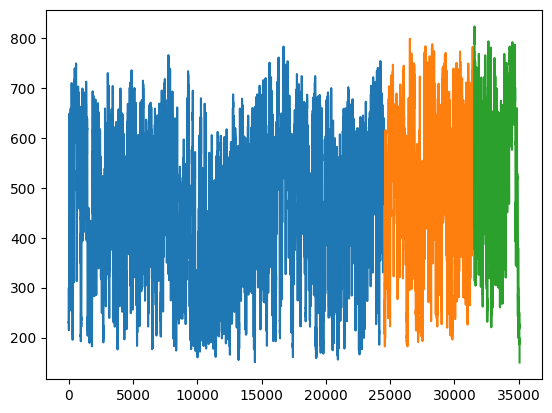

In [36]:
# check the train test split by plotting both

plt.plot(co2_train)
plt.plot(co2_val)
plt.plot(co2_test)
plt.show()

## Create walk forward split

In [37]:
n_val = co2_val.shape[0]
val_split = 8
val_len = n_val // val_split
assert( n_val % val_split == 0)
print('This is the length of the validation data set:', n_val)
print('This is the number of validation splits:', val_split)
print('This is the length of one validation split:', val_len)


This is the length of the validation data set: 7016
This is the number of validation splits: 8
This is the length of one validation split: 877


# Linear Regression

In [ ]:
# Define the  Linear Regression model
regr = LinearRegression( )


In [ ]:
# make a walking forward prediction with the Linear Regression model# av

forecast_period = 24
pred_LR,report_LR = fun.walk_forward_ML(features_train_val ,features_test,co2_train_val,co2_test,regr,forecast_period,'Linear_Regression')
print(report_LR)

d:\ABajrami\Github\Master-Thesis-Probabilistic-Day-Ahead-Forecasting-of-the-German-CO2-Emission-Factor\statistical_models\functions.py:439: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  train_y = pd.concat([train_y,test_y[j:j+forecast_period]])
d:\ABajrami\Github\Master-Thesis-Probabilistic-Day-Ahead-Forecasting-of-the-German-CO2-Emission-Factor\statistical_models\functions.py:439: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  train_y = pd.concat([train_y,test_y[j:j+forecast_peri

MAE for Linear_Regression: 51.39 g_CO2/kWh
MAPE for Linear_Regression: 10.35 %
RMSE for Linear_Regression: 72.69 g_CO2/kWh
R2 Linear_Regression: 74.55000000000001 %


d:\ABajrami\Github\Master-Thesis-Probabilistic-Day-Ahead-Forecasting-of-the-German-CO2-Emission-Factor\statistical_models\functions.py:439: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  train_y = pd.concat([train_y,test_y[j:j+forecast_period]])
d:\ABajrami\Github\Master-Thesis-Probabilistic-Day-Ahead-Forecasting-of-the-German-CO2-Emission-Factor\statistical_models\functions.py:439: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  train_y = pd.concat([train_y,test_y[j:j+forecast_peri

In [ ]:
# save the predictions in a DataFame

pred_LR_df = pd.DataFrame(pred_LR)
pred_LR_df.head()

,0
0,647.290634
1,655.629913
2,662.681704
3,673.901643
4,678.969338


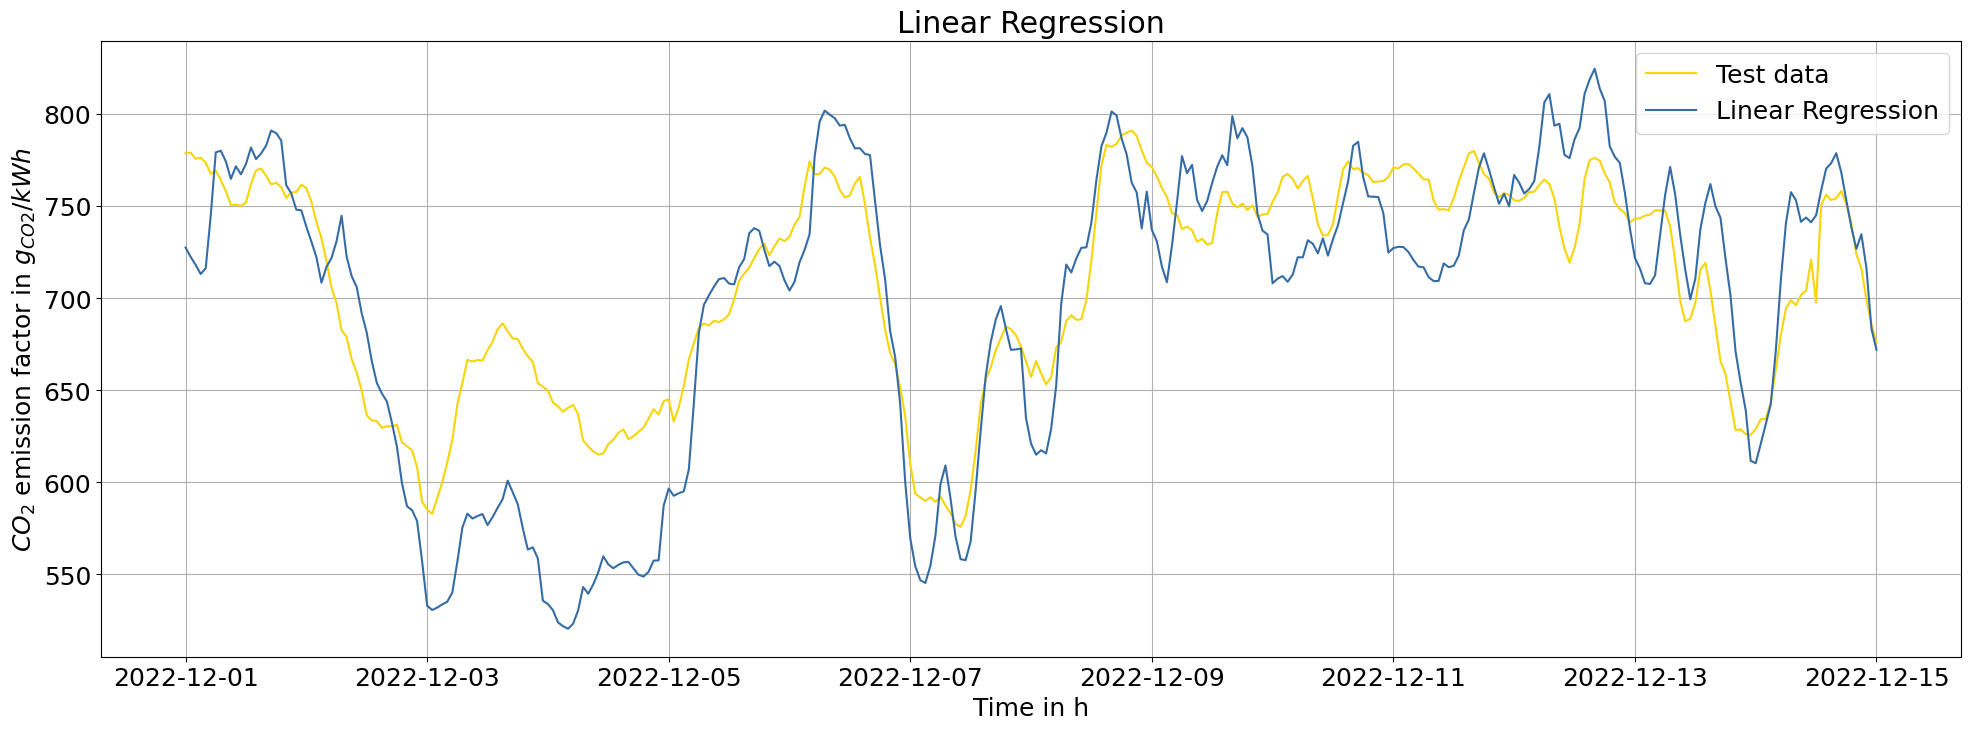

In [ ]:
# Plot prediction vs. test value

fun.plot_model(co2_test, pred_LR_df, date_test, '2022-12-01 00:00', '2022-12-15 00:00', 'Linear Regression')

## Linearity test

In [ ]:
from statsmodels.regression import linear_model 
from statsmodels.stats.diagnostic import linear_reset

In [ ]:
# fit a Linear Regression model

reg = linear_model.OLS(co2,features).fit()

In [ ]:
# Check if the relationship between fetures and target can be described linearly

linear = linear_reset(reg)

In [ ]:
# print the results
print(linear.summary)
print(round(linear.pvalue,4))

## SARIMAX

### Do a Grid Search on train set

In [ ]:
import pmdarima as pm

In [ ]:
# unccomment for shorter time frame for grid search


#co2_train_short = co2[0:int(0.05*len(co2))]
#features_train_short = features[0:int(0.05*len(co2))]
#co2_train_short.shape, features_train_short.shape

In [ ]:
# Do a Grid Search with pmdarima 

model_sarma_auto = pm.auto_arima(co2_train, exogenous = features_train, 
                      start_p=3, start_q=1,
                      #test='adf',       # use adftest to find optimal 'd'
                      max_p=4, max_q=4, # maximum p and q
                      m=24,              # frequency of series
                      d=0,           # let model determine 'd'
                      seasonal=True,   #  Seasonality
                      start_P=1, start_Q=1,
                      max_P= 2, max_Q= 2,
                      D=0, 
                      trace=True,
                      stationary = True, 
                      error_action='trace',  
                      suppress_warnings=False, 
                      stepwise=True,
                      #n_jobs = 6,
                      return_valid_fits= True,
                      max_order= None,
                      maxiter = 15
                        )
print(model_sarma_auto.summary())

In [ ]:

# describe best model results
model_sarma_auto.index

In [ ]:
import joblib

In [ ]:
joblib.dump(model_sarma_auto, 'grid_search_sarmax.pkl')

### Wak forward validation

In [ ]:
# test on validation data
from statsmodels.tsa.statespace.sarimax import SARIMAX
forecast_period =24
config_sarma = (2,0,1)
seasonal_config = (2,0,2,forecast_period)
sarmax = SARIMAX(endog = co2_train, exog= features_train,  order = config_sarma, seasonal_order  = seasonal_config)
sarmax_fit= sarmax.fit()

In [ ]:
# see reulsts for model
sarmax_fit.summary()

In [ ]:
# select the width of the confidence inverval
alpha_low = 0.025
alpha_high = 0.975
ci_width = alpha_high - alpha_low
print( 'width of confidence interval:', ci_width)

pred_sarmax_val,report_sarmax_val,lower_sarmax_val,upper_sarmax_val = fun.walk_forward_validation_sarimax(features_val, co2_val, val_len, sarmax_fit,alpha_low,alpha_high,n_features, 'SARMAX', refit = False)
print(report_sarmax_val)

In [ ]:
report_sarmax_val

In [ ]:
pred_sarmax_val_df = pd.DataFrame(pred_sarmax_val)
pred_sarmax_val_df.head()

In [ ]:
lower_val_df = pd.DataFrame(lower_sarmax_val)
lower_val_df

In [ ]:
upper_val_df = pd.DataFrame(upper_sarmax_val)
upper_val_df

In [ ]:
fun.plot_model_uncertainty2(co2_val, pred_sarmax_val_df,lower_val_df ,upper_val_df, date_val, slice_start = '2022-01-01 23:00', slice_end =  '2022-02-15 23:00' , method = 'SARMAX')

### Test on test data

In [38]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
forecast_period =24
config_sarma = (2,0,1)
seasonal_config = (2,0,2,forecast_period)
sarmax = SARIMAX(endog = co2_train_val, exog= features_train_val,  order = config_sarma, seasonal_order  = seasonal_config)
sarmax_fit= sarmax.fit()

d:\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [48]:
sarmax_fit.test_heteroskedasticity(method = None)

array([[1.14423716e+00, 4.94751042e-12]])

In [40]:
# see reulsts for model
sarmax_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                         emission_factor   No. Observations:                31561
Model:             SARIMAX(2, 0, 1)x(2, 0, [1, 2], 24)   Log Likelihood             -117394.813
Date:                                 Mon, 03 Apr 2023   AIC                         234869.625
Time:                                         12:04:14   BIC                         235204.012
Sample:                                              0   HQIC                        234976.659
                                               - 31561                                         
Covariance Type:                                   opg                                         
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
windon_forecast                   -0.0087      0.000    -81.630      0.000      -0.009      -0.009
windoff_forecast                  -0.0071      0.000    -22.831      0.000      -0.008      -0.006
solar_forecast                    -0.0094      0.000    -73.703      0.000      -0.010      -0.009
prices_forecast                    0.0141      0.005      2.785      0.005       0.004       0.024
aggregated_generation_forecast     0.0030   6.49e-05     45.897      0.000       0.003       0.003
AT_import                          0.0004      0.000      1.163      0.245      -0.000       0.001
AT_export                       6.775e-05      0.000      0.465      0.642      -0.000       0.000
CZ_import                          0.0004      0.000      1.231      0.218      -0.000       0.001
CZ_export                         -0.0005      0.000     -1.541      0.123      -0.001       0.000
DK_import                          0.0013      0.000      5.338      0.000       0.001       0.002
DK_export                          0.0012      0.000      4.002      0.000       0.001       0.002
LU_import                         -0.8553      0.010    -89.230      0.000      -0.874      -0.836
LU_export                          0.0660      0.004     16.471      0.000       0.058       0.074
NL_import                          0.0009      0.000      3.981      0.000       0.000       0.001
NL_export                       9.012e-06      0.000      0.055      0.956      -0.000       0.000
PL_import                          0.0014      0.000      2.868      0.004       0.000       0.002
PL_export                          0.0037      0.001      7.068      0.000       0.003       0.005
CH_import                         -0.0004      0.000     -1.571      0.116      -0.001       0.000
CH_export                         -0.0005      0.000     -1.256      0.209      -0.001       0.000
co2_24_lag                         0.1262      0.006     20.513      0.000       0.114       0.138
co2_26_lag                         0.0267      0.006      4.174      0.000       0.014       0.039
day_of_week_fri                  349.0356      5.302     65.833      0.000     338.644     359.427
day_of_week_mon                  367.0140      5.227     70.218      0.000     356.770     377.258
day_of_week_sat                  333.7878      5.270     63.337      0.000     323.459     344.117
day_of_week_sun                  340.3911      5.225     65.148      0.000     330.150     350.632
day_of_week_thu                  354.5000      5.345     66.327      0.000     344.024     364.975
day_of_week_tue                  360.9709      5.323     67.816      0.000     350.538     371.403
day_of_week_wed                  358.1251      5.329     67.200      0.000     347.680     368.570
hour_of_day_sin    

In [41]:
# select the width of the confidence inverval
alpha_low = 0.025
alpha_high = 0.975
ci_width = alpha_high - alpha_low
print( 'width of confidence interval:', ci_width)

pred_sarmax_test,report_sarmax_test,lower_sarmax_test,upper_sarmax_test = fun.walk_forward_validation_sarimax(features_test, co2_test, forecast_period, sarmax_fit,alpha_low,alpha_high,n_features, 'SARMAX')
print(report_sarmax_test)

width of confidence interval: 0.95


d:\ABajrami\Github\Master-Thesis-Probabilistic-Day-Ahead-Forecasting-of-the-German-CO2-Emission-Factor\statistical_models\functions.py:351: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  train_update = test_y[j:j+forecast_period]
d:\ABajrami\Github\Master-Thesis-Probabilistic-Day-Ahead-Forecasting-of-the-German-CO2-Emission-Factor\statistical_models\functions.py:351: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  train_update = test_y[j:j+forecast_period]
d:\ABajrami\Github\Master-

MAE for SARMAX: 48.02 g_CO2/kWh
MAPE for SARMAX: 9.16 %
RMSE for SARMAX: 63.64 g_CO2/kWh
Pinball for lower Quantile SARMAX: 3.4 g_CO2/kWh
Pinball for higher Quantile SARMAX: 6.02 g_CO2/kWh
Interval Score SARMAX: 176.4253 g_CO2/kWh
Real Values insisde PI SARMAX: 86.76 %
R2 SARMAX: 80.49 %
Adjusted R2 SARMAX: 80.31 %


In [49]:
print(report_sarmax_test)

MAE for SARMAX: 48.02 g_CO2/kWh
MAPE for SARMAX: 9.16 %
RMSE for SARMAX: 63.64 g_CO2/kWh
Pinball for lower Quantile SARMAX: 3.4 g_CO2/kWh
Pinball for higher Quantile SARMAX: 6.02 g_CO2/kWh
Interval Score SARMAX: 176.4253 g_CO2/kWh
Real Values insisde PI SARMAX: 86.76 %
R2 SARMAX: 80.49 %
Adjusted R2 SARMAX: 80.31 %


In [50]:
pred_sarmax_df = pd.DataFrame(pred_sarmax_test)
pred_sarmax_df.to_csv('sarmax_mean_wf_test.csv')
pred_sarmax_df.head()

,0
0,801.307202
1,798.716061
2,785.832742
3,776.196133
4,761.235206


In [51]:
upper_test_df = pd.DataFrame(upper_sarmax_test)
upper_test_df.to_csv('sarmax_upper_wf_test.csv')
upper_test_df.head()

,0
0,824.466896
1,840.076375
2,841.080135
3,841.679210
4,834.192551


In [52]:
lower_test_df = pd.DataFrame(lower_sarmax_test)
lower_test_df.to_csv('sarmax_lower_wf_test.csv')
lower_test_df

,0
0,778.147508
1,757.355747
2,730.585349
3,710.713057
4,688.277861
...,...
3499,168.112411
3500,118.757485
3501,122.825916
3502,104.821866


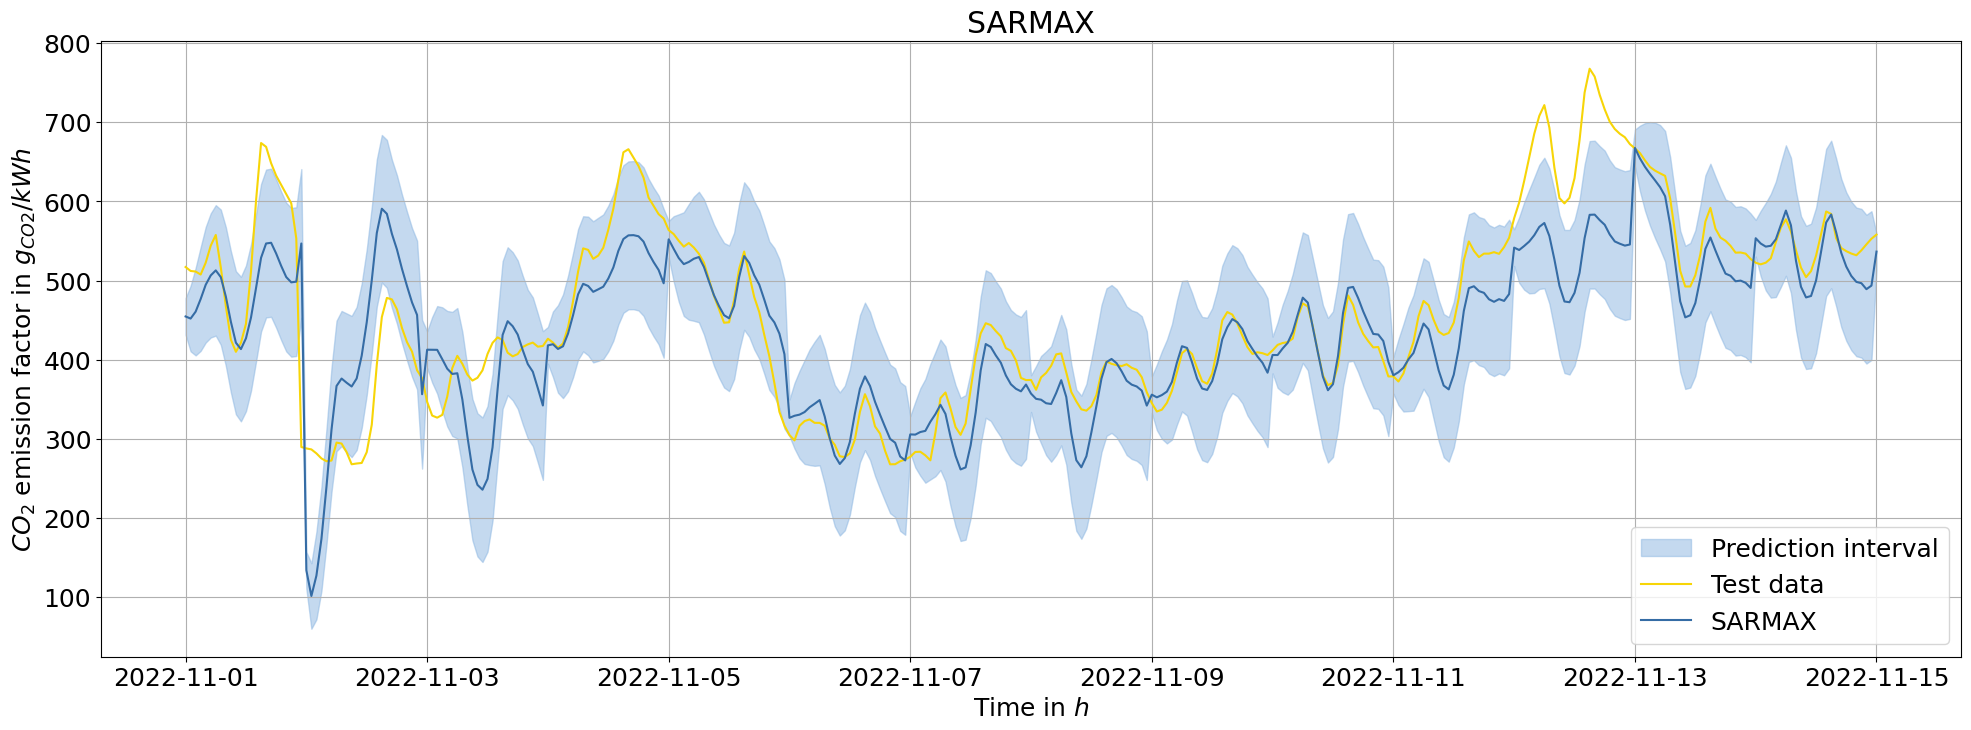

In [56]:
fun.plot_model_uncertainty(co2_test, pred_sarmax_df, lower_test_df , upper_test_df, date_test, '2022-11-01 00:00', '2022-11-15 00:00', 'SARMAX')

In [47]:
# save the model for future usage
joblib.dump(sarmax_fit, 'saramx_model.pkl')

NameError: name 'joblib' is not defined